<a href="https://colab.research.google.com/github/CIS-522/course-content/blob/main/tutorials/W3_MLPs/W3_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning: Week 3
# Multi-Layer Perceptrons (MLPs)

__Instructor__: Konrad Kording

__Content creators:__ Arash Ash

---
# Tutorial Objectives
In this tutorial, we delve deeper by using one of the most famous deep learning models of all!

MLPs are arguably one of the most tractable models that we can use to study deep learning fundamentals. Here we will learn why MLPs are: 

* similiar to biological networks
* good at function approximation
* can evolve linearly in weights 
* the case of deep vs. wide
* dependedant on transfer functions
* sensitive to initialization

# Recap the experience from last week

Tell us your thoughts about what you have learned



In [1]:
# report to Airtable

# Question of the week
What functional forms are good or bad for representing complex functions?

[answers include differentiable, hierarchical, smooth, dynamical, nonlinear]

---
# Setup

In [2]:
# Imports
import time
import random
import pathlib

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
from IPython.display import HTML, display

seed = 522
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_deterministic(True)

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dev, torch.get_num_threads()

(device(type='cpu'), 20)

In [3]:
# @title Dataset download
%%capture
!rm -r AnimalFaces32x32/
!git clone https://github.com/arashash/AnimalFaces32x32
!rm -r afhq/
!unzip ./AnimalFaces32x32/afhq_32x32.zip 

In [4]:
# @title Figure Settings
import ipywidgets as widgets
%matplotlib inline 
fig_w, fig_h = (8, 6)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
%config InlineBackend.figure_format = 'retina'
my_layout = widgets.Layout()

In [5]:
# @title Helper functions
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis(False)
    plt.show()

def progress(epoch, loss, epochs=100):
    return HTML("""
        <label for="file">Training loss: {loss}</label>
        <progress
            value='{epoch}'
            max='{epochs}',
            style='width: 100%'
        >
            {epoch}
        </progress>
    """.format(loss=loss, epoch=epoch, epochs=epochs))

# Neuron Physiology
[Motivation, F-I Curve, Video Summary]

In [6]:
#@title Video 1:

## Leaky Integrate and Fire (LIF) Neuron
Now, it's your turn to implement one of the simplest mathematical model of a neuron: the leaky integrate-and-fire (LIF) model. The basic idea of LIF neuron was proposed in 1907 by Louis Édouard Lapicque, long before we understood the electrophysiology of a neuron (see a translation of [Lapicque's paper](https://pubmed.ncbi.nlm.nih.gov/17968583/) ). More details of the model can be found in the book [**Theoretical neuroscience**](http://www.gatsby.ucl.ac.uk/~dayan/book/) by Peter Dayan and Laurence F. Abbott.

The model dynamic is defined with the following formula,

$$
\frac{d V}{d t}=\left\{\begin{array}{cc}
\frac{1}{R_{m}C_{m}}\left(-V+I R_{m}\right) & t>t_{r e s t} \\
0 & \text { otherwise }
\end{array}\right.
$$

And If $I$ is sufficiently strong such that $V$ reaches a certain threshold value $V_{\rm th}$, it momentarily spikes and then $V$ is reset to $V_{\rm reset}< V_{\rm th}$, and voltage stays at $V_{\rm reset}$ for $\tau_{\rm ref}$ ms, mimicking the refractoriness of the neuron during an action potential:

\begin{eqnarray}
V(t)=V_{\rm reset} \text{  for } t\in(t_{\text{sp}}, t_{\text{sp}} + \tau_{\text{ref}}]
\end{eqnarray}

where $t_{\rm sp}$ is the spike time when $V(t)$ just exceeded $V_{\rm th}$.

For an in-depth content follow the [NMA](https://www.neuromatchacademy.org/) Week 3 Day 1 materials on Real Neurons and specificially this [Tutorial](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W3D1_RealNeurons/W3D1_Tutorial1.ipynb)


## Exercise 1: Simulating an LIF Neuron

[summary of the process]

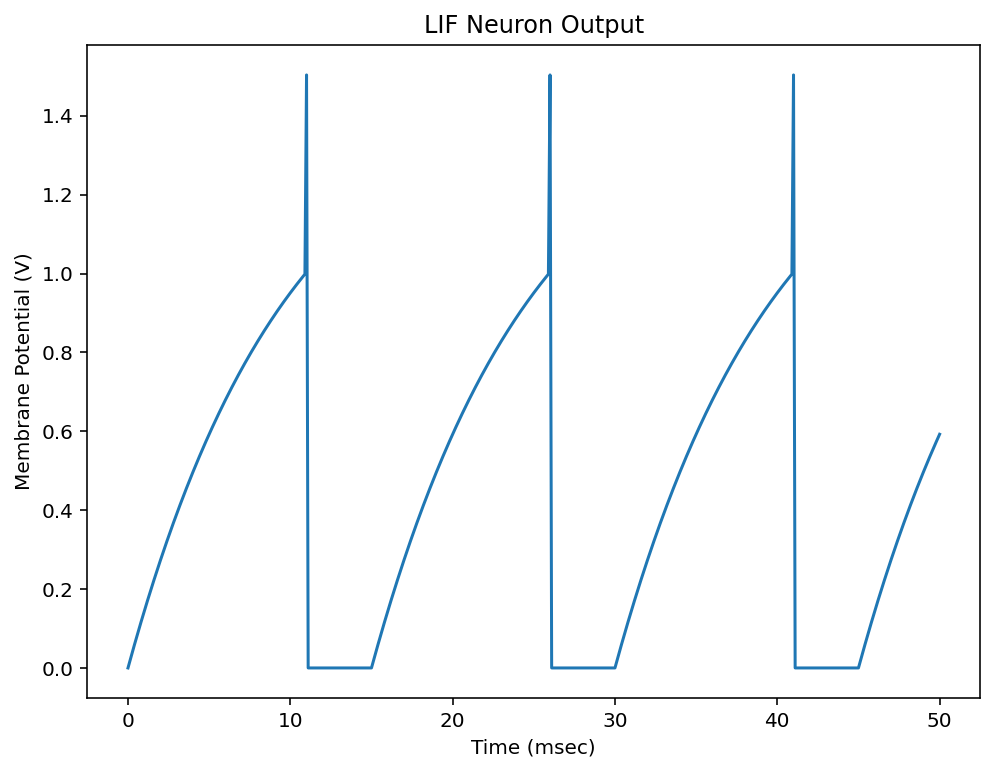

In [7]:
def run_LIF(I, # input current (mA)
            T = 50, # total time to simulate (msec)
            dt = 0.1, # simulation time step (msec)
            t_rest = 0, # initial refractory time
            Rm = 1, # resistance (kOhm)
            Cm = 10, # capacitance (uF)
            tau_ref = 4, # refractory period (msec)
            Vth = 1, # spike threshold (V)
            V_spike = 0.5 # spike delta (V)
            ):

  # time constant (msec)
  tau_m = Rm*Cm  # [TO-DO]
  time = torch.arange(0, T+dt, dt) # [TO-DO]
  
  # potential (V) trace over time
  Vm = torch.zeros(len(time)) 

  # iterate over each time step
  for i, t in enumerate(time):
    if t > t_rest:
      Vm[i] = Vm[i-1] + (-Vm[i-1] + I*Rm) / tau_m * dt # [TO-DO]
    if Vm[i] >= Vth:
      Vm[i] += V_spike # [TO-DO]
      t_rest = t + tau_ref # [TO-DO]
  return time, Vm

time, Vm = run_LIF(1.5)
# plot membrane potential trace
plt.plot(time, Vm)
plt.title('LIF Neuron Output')
plt.ylabel('Membrane Potential (V)')
plt.xlabel('Time (msec)')
plt.show()

In [8]:
@widgets.interact(Rm=widgets.FloatSlider(1., min=0.5, max=10., step=0.1, layout=my_layout))

def plot_IF_curve(Rm):
  T = 100 # total time to simulate (msec)
  dt = 1 # simulation time step (msec)
  Vth = 1 # spike threshold (V)
  Is = torch.linspace(0, 2, 10)
  spike_counts = []
  for I in Is:
    _, Vm = run_LIF(I, T = T, Vth = Vth, Rm=Rm)
    spike_counts += [torch.sum(Vm > Vth)] # [TO-DO]

  plt.plot(Is, spike_counts)
  plt.title('LIF Transfer Function (I/F Curve)')
  plt.ylabel('Spike count')
  plt.xlabel('I (mA)')
  plt.show()

interactive(children=(FloatSlider(value=1.0, description='Rm', max=10.0, min=0.5), Output()), _dom_classes=('w…

# The need for MLPs
[Motivation, Linear separation, XOR problem]

In [9]:
#@title Video 2:

## Exercise 2: Solving XOR 

* Play with the widget and observe that you can not solve XOR
* Now add one hidden layer with 3 units, play with the widget and set weights by hand to solve XOR perfectly.

For second part, you should set the weights by clicking on the connections and either type the value or use the up and down keys to change it by one increment. You could also do the same for the biases by clicking on the tiny square to each neuron's bottom left.
A neat solution with $f(x) = max(0,x)$: 

$$y = f(x_1)+f(x_2)-f((x_1+x_2))$$

Note that due to the the plotting implementation, all the weights should be set to larger value than 1. like 10. in order for the outputs to give very large or very small values (this is probably because they used sigmoid activation and thresholding in the plotting instead of simply checking the sign)

In [10]:
# @title XOR Exercise
from IPython.display import HTML
HTML('<iframe width="1020" height="660" src="https://playground.arashash.com/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=&seed=0.91390&showTestData=false&discretize=false&percTrainData=90&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false" allowfullscreen></iframe>')

# The idea of approximating with ReLUs
[What is a basis function, how to do function approximation with basis functions? maybe mentioning fourier transform? and why ReLU is a good basis function? connection with LIF model]

In [11]:
#@title Video 3:

## Exercise 3: Function Approximation with ReLU

[]

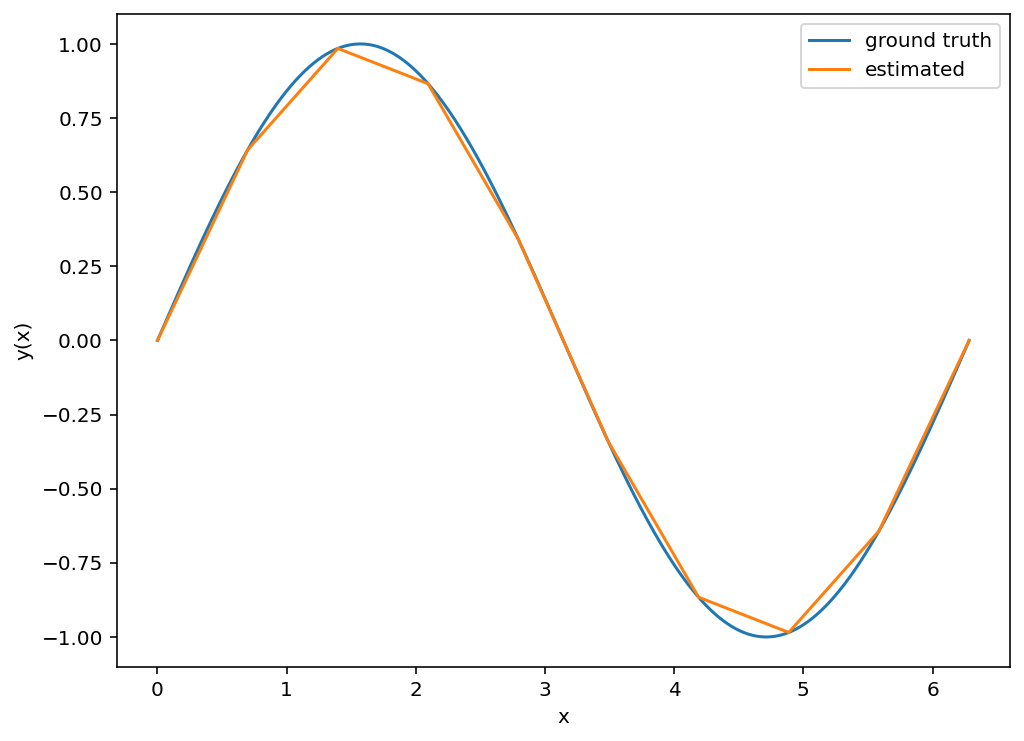

In [12]:
N_test = 1000
x_test = torch.linspace(0, 2*np.pi, N_test).view(-1, 1)
y_test = torch.sin(x_test)
plt.plot(x_test, y_test, label='ground truth')

N_train = 10
x_train = torch.linspace(0, 2*np.pi, N_train).view(-1, 1)
y_train = torch.sin(x_train)

W1 = torch.ones(1, N_train)  # [TO-DO]
b1 = - x_train.view(N_train)  # [TO-DO]

W2 = torch.zeros(N_train, 1)  # [TO-DO]
prev_slope = 0
for i in range(N_train-1):
  delta_x = x_train[i+1] - x_train[i]  # [TO-DO]
  slope = (y_train[i+1] - y_train[i]) / delta_x  # [TO-DO]
  W2[i] = slope - prev_slope  # [TO-DO]
  prev_slope = slope

y_hat = torch.relu(b1 + x_test @ W1) @ W2  # [TO-DO]

plt.plot(x_test, y_hat, label='estimated')
plt.legend()
plt.xlabel('x')
plt.ylabel('y(x)')
plt.plot()

# Completeness proof sketch
[do one part of the completeness proof in math]

In [13]:
#@title Video 4:

## Exercise 4: Implement a general purpose MLP in Pytorch
[Outline the objectives of the model, i.e., should work with any activations, and any depth]

[why flattening iniallially (since we want to use with any dataset inluding image datasets, why we don't use activation at output layer?]

In [14]:
class Net(nn.Module):
    def __init__(self, actv, num_inputs, hidden_units, num_outputs):
        super(Net, self).__init__()

        exec('self.actv = nn.%s'%actv)   # [TO-DO]

        self.layers = nn.ModuleList()
        for i in range(len(hidden_units)):
          next_num_inputs = hidden_units[i] 
          self.layers += [nn.Linear(num_inputs, next_num_inputs)]   # [TO-DO]
          num_inputs = next_num_inputs

        self.out = nn.Linear(num_inputs, num_outputs)

    def forward(self, x):
        # flattening
        x = x.view(x.shape[0], -1)   # [TO-DO]

        for layer in self.layers:
          x = self.actv(layer(x))  # [TO-DO]
        x = self.out(x) # [TO-DO]
        return x

Net(actv='LeakyReLU(0.1)',
    num_inputs = 2,
    hidden_units = [100, 10, 5],
    num_outputs = 1)

Net(
  (actv): LeakyReLU(negative_slope=0.1)
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=5, bias=True)
  )
  (out): Linear(in_features=5, out_features=1, bias=True)
)

# ReLU in practice
[Open the code for ReLU. Make it into leaky ReLU. Answer *why* ReLU is not implemented as x_out=x_in*(x_in>0)]

[Let us understand limited bit-width, Let us look at ReLU6. Why that way?]


In [15]:
#@title Video 5:

## Exercise 5: Benchmark Various ReLU Implementation
Implement and benchmark at least three different ReLU implementations
[Motivate students to get closer in time with Pytorch implementation]
[introduce efficient array operations in Pytorch]


In [16]:
x = torch.rand((5000, 5000)).to(dev) - 0.5
print("Pytorch : ", end='')
%timeit -n10 torch.relu(x)
print('-----------------------------------------------')

print("First: ", end='')
%timeit -n10 torch.max(x, torch.zeros_like(x))   # [TO-DO]
print('-----------------------------------------------')

print("Second: ", end='')
%timeit -n10 x * (x > 0)   # [TO-DO]
print('-----------------------------------------------')

print("Third: ", end='')
%timeit -n10 (torch.abs(x) + x) / 2   # [TO-DO]
print('-----------------------------------------------')

print("Forth: ", end='')
%timeit -n10 x[x<0] = 0   # [TO-DO]

Pytorch : 10 loops, best of 3: 5.49 ms per loop
-----------------------------------------------
First: 10 loops, best of 3: 11.7 ms per loop
-----------------------------------------------
Second: 10 loops, best of 3: 15.3 ms per loop
-----------------------------------------------
Third: 10 loops, best of 3: 18.1 ms per loop
-----------------------------------------------
Forth: 10 loops, best of 3: 18.9 ms per loop


# Classification 
[Cross entropy - and the softmax function]

In [17]:
#@title Video 6:

## Exercise 6: Simulate a Spiral Classification Dataset
[introduce the math here]

$$
\begin{array}{c}
X_{k}(t)=t\left(\begin{array}{c}
\sin \left[\frac{2 \pi}{K}\left(2 t+k-1\right)\right]+\mathcal{N}\left(0, \sigma^{2}\right) \\
\cos \left[\frac{2 \pi}{K}\left(2 t+k-1\right)\right]+\mathcal{N}\left(0, \sigma^{2}\right) 
\end{array}\right)
\end{array}, \quad 0 \leq t \leq 1, \quad k=1, \ldots, K
$$

[]

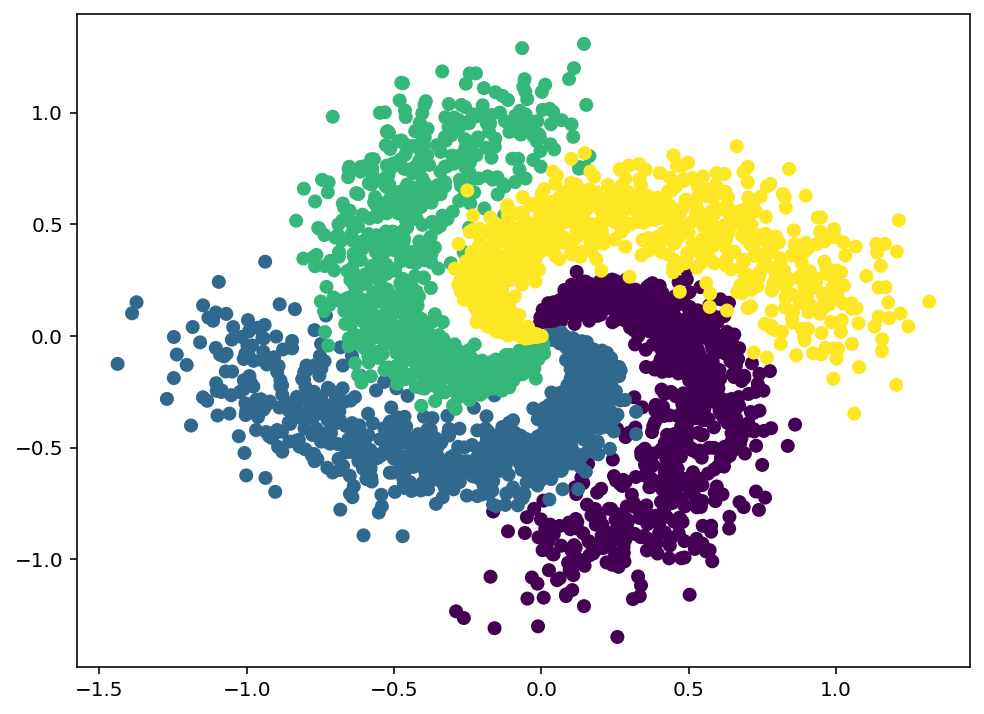

In [18]:
K = 4
sigma = 0.4
N = 1000
t = torch.linspace(0, 1, N)
X = torch.zeros(K*N, 2)
y = torch.zeros(K*N)
for k in range(K):
  X[k*N:(k+1)*N, 0] = t*(torch.sin(2*np.pi/K*(2*t+k)) + sigma**2*torch.randn(N))   # [TO-DO]
  X[k*N:(k+1)*N, 1] = t*(torch.cos(2*np.pi/K*(2*t+k)) + sigma**2*torch.randn(N))   # [TO-DO]
  y[k*N:(k+1)*N] = k   # [TO-DO]

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.plot()

[]

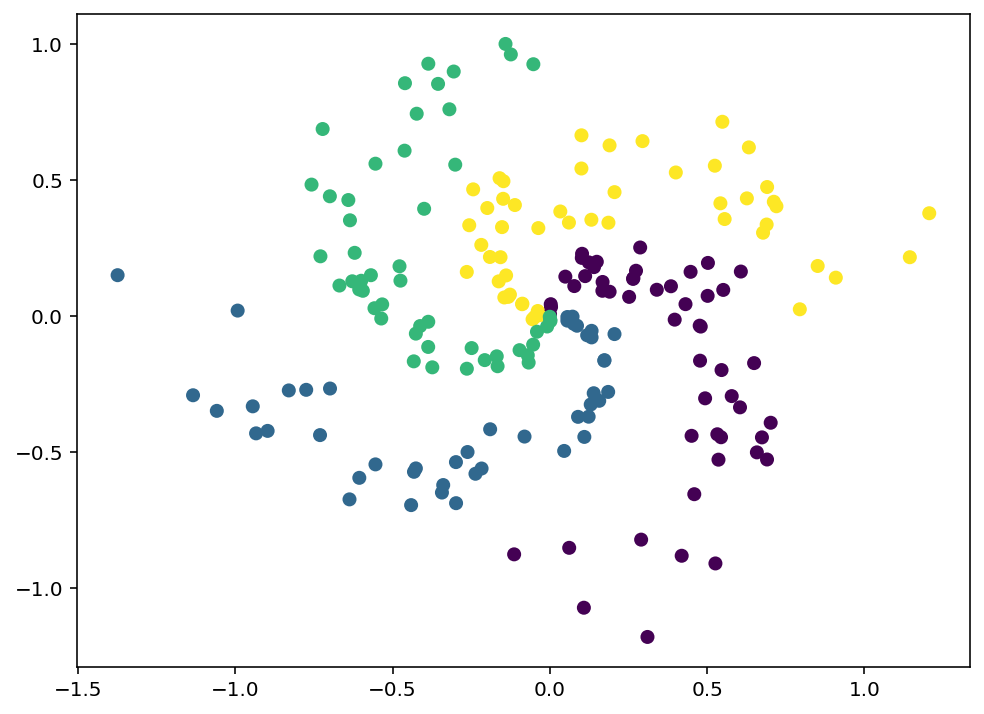

In [19]:
# Shuffling
shuffled_indeces = torch.randperm(K*N)   # [TO-DO]
X = X[shuffled_indeces]
y = y[shuffled_indeces]

# Test Train splitting
test_size = int(0.2*N)   # [TO-DO]
X_test = X[:test_size]
y_test = y[:test_size]
X_train = X[test_size:]
y_train = y[test_size:]
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.plot()

In [20]:
batch_size = 128
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                        shuffle=False, num_workers=1)
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size,
                        shuffle=True, num_workers=1)

## Exercise 7: Implement Train and Test 
[Outline the goal and steps]

In [21]:
def train_test_classification(net, criterion, optimizer,
                              train_loader, test_loader,
                              num_epochs=1, verbose=True, 
                              training_plot=False):
  if verbose:
    progress_bar = display(progress(0, 0, num_epochs), display_id=True)

  net.train()   # [TO-DO]
  training_losses = []
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, data in enumerate(train_loader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(dev).float()    # [TO-DO]
          labels = labels.to(dev).long()   # [TO-DO]

          # zero the parameter gradients
          optimizer.zero_grad()   # [TO-DO]

          # forward + backward + optimize
          outputs = net(inputs)   # [TO-DO]

          loss = criterion(outputs, labels)   # [TO-DO]
          loss.backward()   # [TO-DO]
          optimizer.step()   # [TO-DO]

          # print statistics
          if verbose:
            training_losses += [loss.item()]
            running_loss += loss.item()
            if i % 10 == 9:    # update every 10 mini-batches
                progress_bar.update(progress(epoch+1, running_loss / 10, num_epochs))
                running_loss = 0.0

  net.eval()   # [TO-DO]
  def test(data_loader):
    correct = 0
    total = 0
    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(dev).float()
        labels = labels.to(dev).long()

        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)   # [TO-DO]
        total += labels.size(0)   # [TO-DO]
        correct += (predicted == labels).sum().item()   # [TO-DO]

    acc = 100 * correct / total    # [TO-DO]
    return total, acc

  total, train_acc = test(train_loader)
  total, test_acc = test(test_loader)

  if verbose:
    print('Accuracy on the %d training samples: %0.2f %%' % (total, train_acc))
    print('Accuracy on the %d testing samples: %0.2f %%' % (total, test_acc))

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()
  
  return train_acc, test_acc

Accuracy on the 200 training samples: 98.16 %
Accuracy on the 200 testing samples: 97.50 %


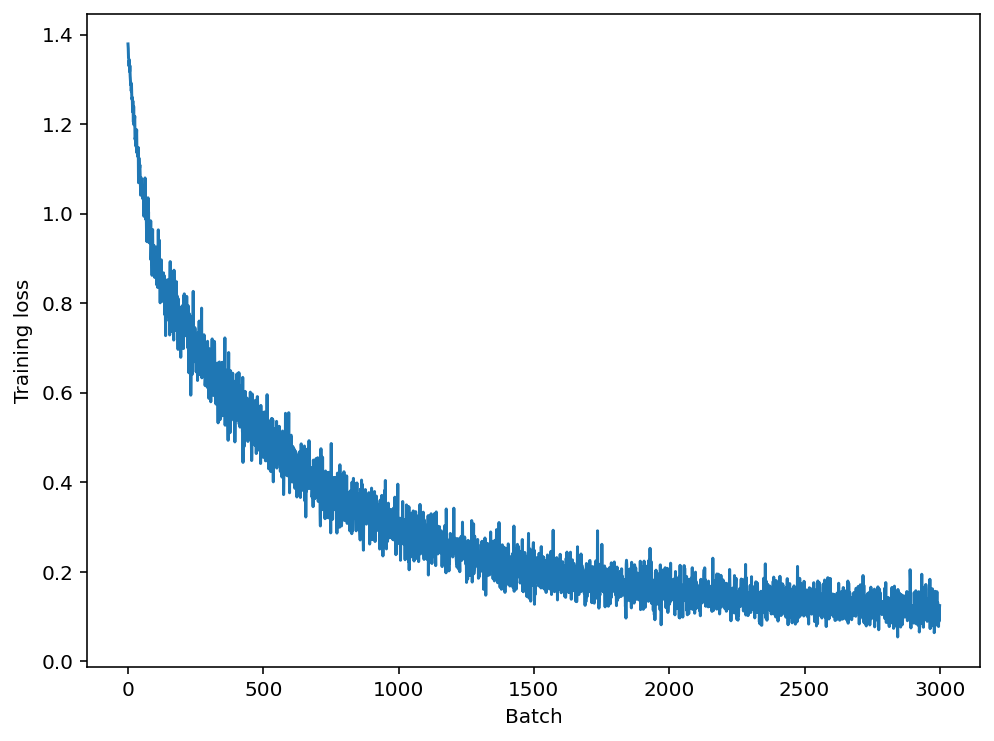

In [22]:
net = Net('ReLU()', X_train.shape[1], [128], K).to(dev)    # [TO-DO] 
criterion = nn.CrossEntropyLoss()    # [TO-DO]
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 100
_, _ = train_test_classification(net, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True)

## Exercise 8: Implement decision map visualization
[Outline the goal and steps]

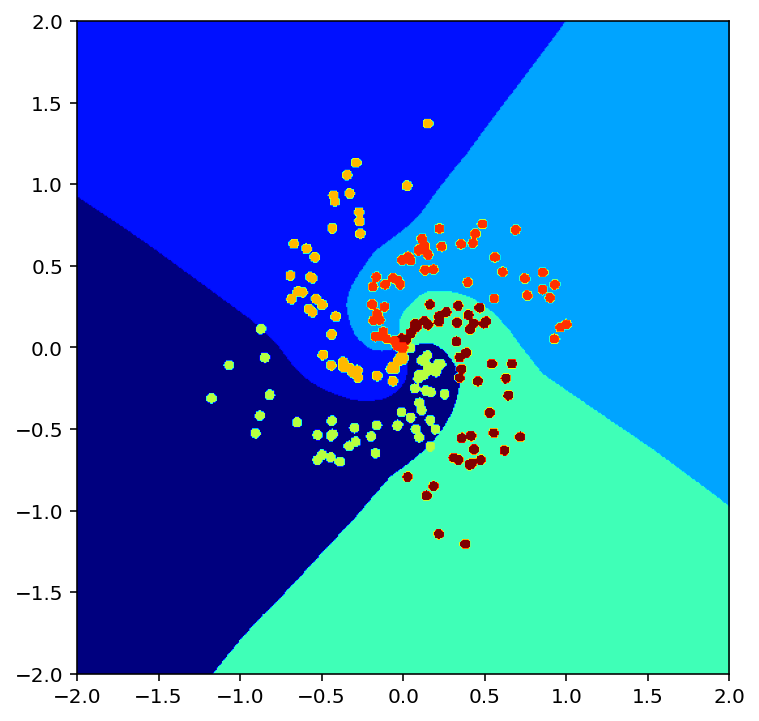

In [23]:
def sample_grid(M=500, x_max = 2.0):
  ii, jj = torch.meshgrid(torch.linspace(-x_max, x_max,M),
                          torch.linspace(-x_max, x_max, M))
  X_all = torch.cat([ii.unsqueeze(-1),
                     jj.unsqueeze(-1)],
                     dim=-1).view(-1, 2)    # [TO-DO]
  return X_all

def plot_decision_map(X_all, y_pred, X_test, y_test, M=500, x_max = 2.0, eps = 1e-3):
  decision_map = torch.argmax(y_pred, dim=1)    # [TO-DO]

  for i in range(len(X_test)):
    indeces = (X_all[:, 0] - X_test[i, 0])**2 + (X_all[:, 1] - X_test[i, 1])**2 < eps    # [TO-DO]
    decision_map[indeces] = (K + y_test[i]).long()    # [TO-DO]

  decision_map = decision_map.view(M, M).cpu()
  plt.imshow(decision_map, extent=[-x_max, x_max, -x_max, x_max], cmap='jet')
  plt.plot()

X_all = sample_grid()
y_pred = net(X_all)
plot_decision_map(X_all, y_pred, X_test, y_test)

## Exercise 8 Part 2: Implement gradient visualization
[Outline the goal and steps]

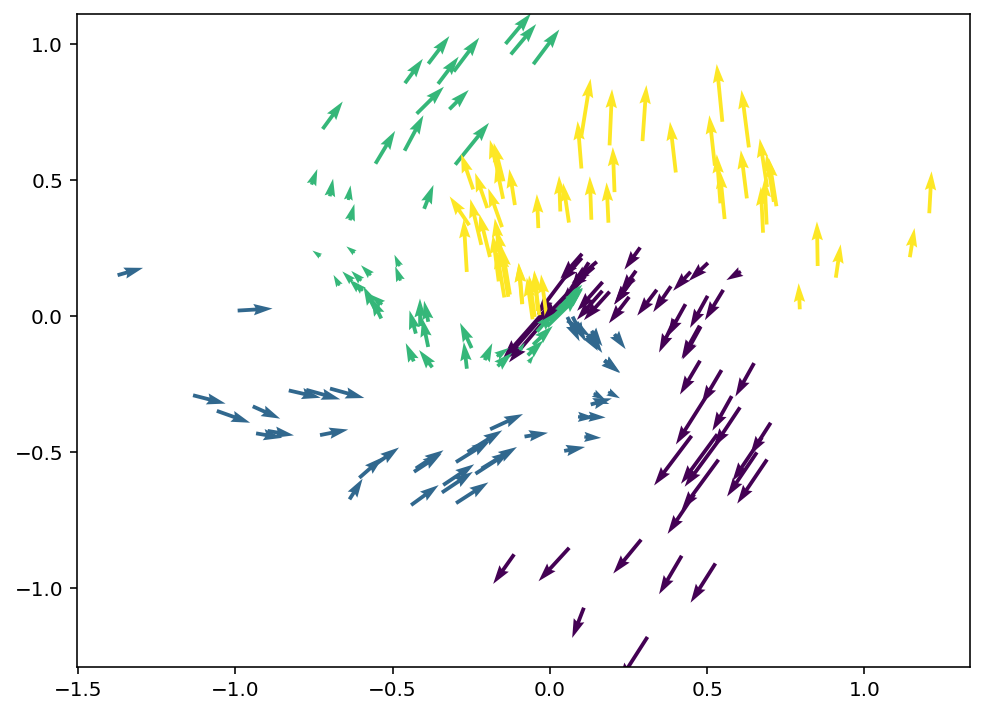

In [24]:
def plot_grad(X_all, grad, y_test, M=500):
  grad = grad.detach().cpu()
  X_all = X_all.detach().cpu()

  plt.quiver(X_all[:, 0], X_all[:, 1],
             grad[:, 0], grad[:, 1], y_test)    # [TO-DO]
  plt.show()

rand_net = Net('ReLU()', X_train.shape[1], [128], K).to(dev)
X_test.requires_grad = True    # [TO-DO]
outputs = rand_net(X_test)

loss = criterion(outputs, y_test.long())    # [TO-DO]
loss.backward()

plot_grad(X_test, X_test.grad, y_test)    # [TO-DO]
X_test.requires_grad = False    # [TO-DO]

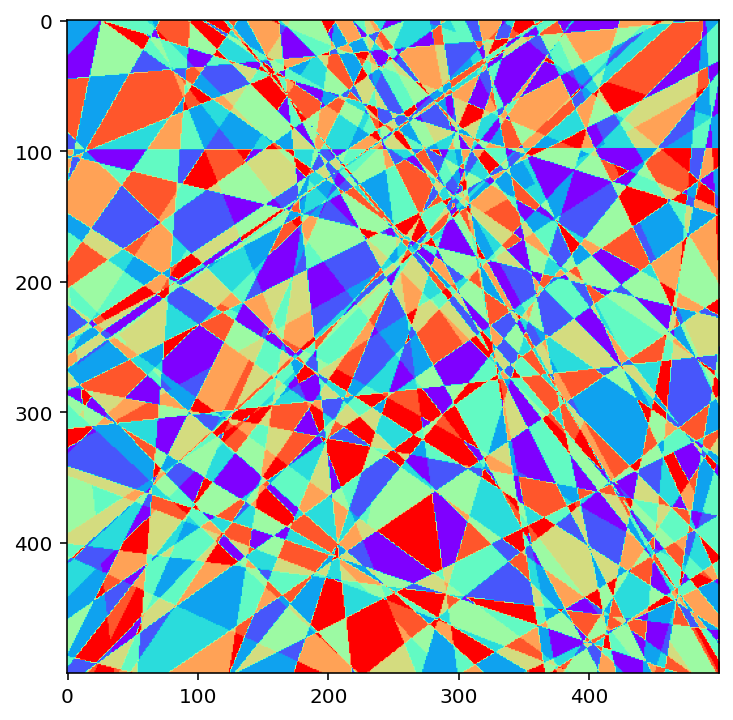

In [25]:
def plot_polytopes(grad, M=500, x_max=1):
  grad = grad.detach().cpu()
  grad_colors = grad[:, 0]     # [TO-DO]
  grad_colors = (grad_colors / grad_colors.max() * 1e3).int() % 10     # [TO-DO]
  grad_colors = grad_colors.view(M, M).cpu().numpy()
  plt.imshow(grad_colors, cmap='rainbow')
  plt.show()

rand_net = Net('ReLU()', X_train.shape[1], [128], K).to(dev)

criterion = nn.CrossEntropyLoss()
X_all = sample_grid(x_max=1)
labels = torch.zeros(len(X_all)).long()
X_all.requires_grad = True    # [TO-DO]
outputs = rand_net(X_all)

loss = torch.mean(outputs)    # [TO-DO]
# loss = torch.mean(outputs**2) # try this to see how it become non-linear
loss.backward()

plot_polytopes(X_all.grad)    # [TO-DO]

## Exercise 8 Part 3: Wider vs. Deeper while keeping number of parameters same
[Outline the goal and steps]

In [26]:
def count_parameters(model):
  # facny implementation
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_parameters(model):
  # more didactic implementation
  par_count = 0
  for p in model.parameters():
    if p.requires_grad:
      par_count += p.numel()     # [TO-DO]
  return par_count

Accuracy on the 200 training samples: 67.74 %
Accuracy on the 200 testing samples: 69.00 %


Accuracy on the 200 training samples: 88.03 %
Accuracy on the 200 testing samples: 89.50 %


Accuracy on the 200 training samples: 96.82 %
Accuracy on the 200 testing samples: 95.50 %


Accuracy on the 200 training samples: 88.03 %
Accuracy on the 200 testing samples: 85.00 %


Accuracy on the 200 training samples: 74.05 %
Accuracy on the 200 testing samples: 76.00 %


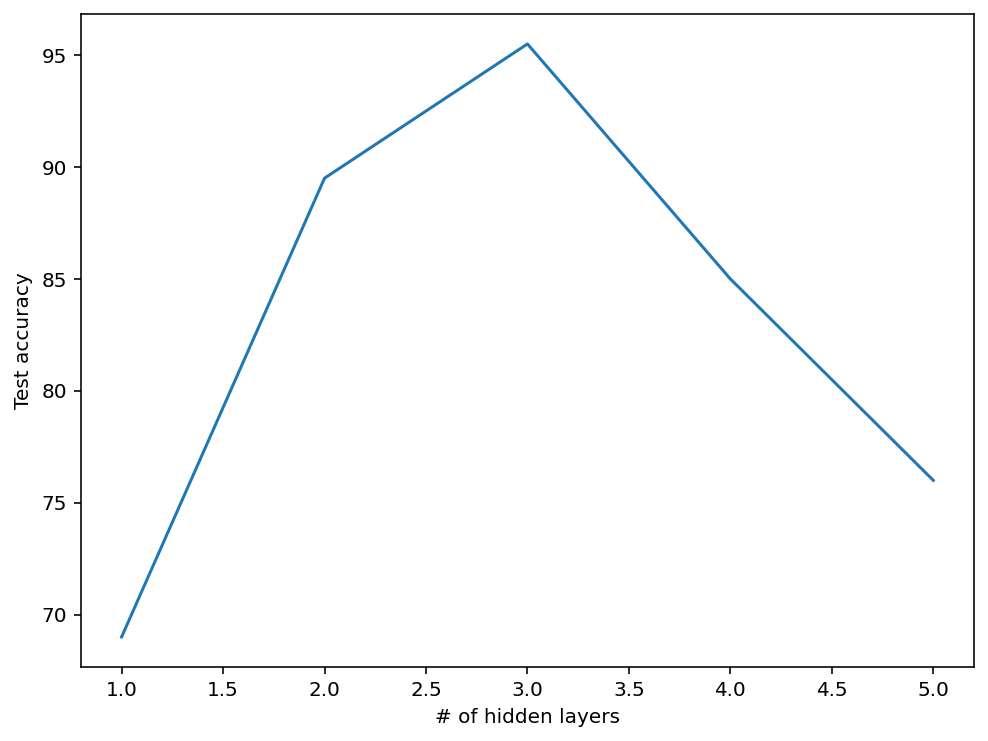

In [27]:
max_par_count = 100
max_hidden_layer = 5
hidden_layers = range(1, max_hidden_layer+1)    # [TO-DO]
test_scores = []
for hidden_layer in hidden_layers:
  hidden_units = np.ones(hidden_layer, dtype=np.int)    # [TO-DO]
  wide_net = Net('ReLU()', X_train.shape[1], hidden_units, K).to(dev)
  par_count = count_parameters(wide_net)
  while par_count < max_par_count:
    hidden_units += 1
    wide_net = Net('ReLU()', X_train.shape[1], hidden_units, K).to(dev)
    par_count = count_parameters(wide_net)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(wide_net.parameters(), lr=1e-3)
  num_epochs = 100
  _, test_acc = train_test_classification(wide_net, criterion, optimizer, train_loader,
                                          test_loader, num_epochs=num_epochs)    # [TO-DO]
  test_scores += [test_acc]

plt.xlabel('# of hidden layers')
plt.ylabel('Test accuracy')
plt.plot(hidden_layers, test_scores)
plt.show()

## Exercise 8 Part 4: Motivation for NTKs
lazy training of overcomplete MLPs results in small changes in weights
[Outline the goal and steps]

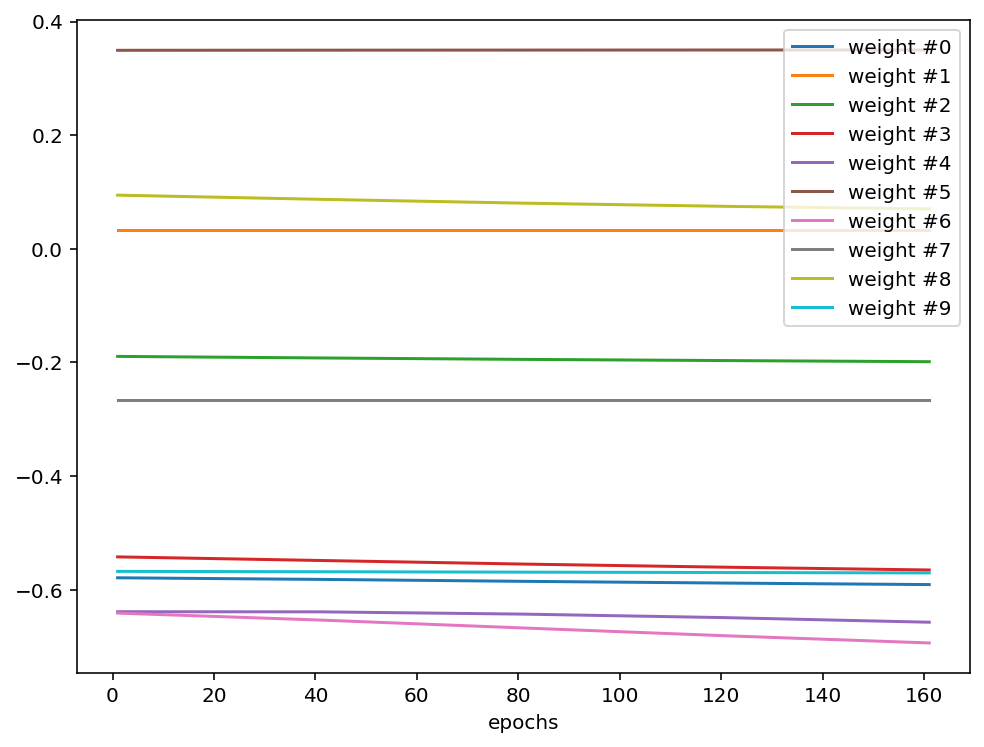

Accuracy on the 200 training samples: 84.89 %
Accuracy on the 200 testing samples: 87.50 %


In [28]:
net = Net('ReLU()', X_train.shape[1], [1000], K).to(dev)    # [TO-DO] 
criterion = nn.CrossEntropyLoss()    # [TO-DO]
optimizer = optim.SGD(net.parameters(), lr=1e-2)    # [TO-DO]
num_select_weights = 10
num_time_steps = 5
step_epoch = 40
weights = torch.zeros(num_time_steps, num_select_weights)
for i in range(num_time_steps):
  _, _ = train_test_classification(net, criterion, optimizer, train_loader,
                                  test_loader, num_epochs=step_epoch, verbose=False)
  weights[i] = net.layers[0].weight[:num_select_weights, 0]    # [TO-DO]

for k in range(num_select_weights):
  weight = weights[:, k].detach()    # [TO-DO]
  epochs = range(1, 1+num_time_steps*step_epoch, step_epoch)
  plt.plot(epochs, weight, label='weight #%d'%k)

plt.xlabel('epochs')
plt.legend()
plt.show()
_, _ = train_test_classification(net, criterion, optimizer, train_loader, test_loader, num_epochs=1)

# Fitting a high order polynomial sucks
[Why polynomial is a terrible basis function]

In [29]:
#@title Video 7:

## Exercise 9: Add polynomial features and train without any hidden layers
[Outline the goal and steps and the formulas, especially how the num_features is calculated]

In [30]:
poly_degree = 10
def make_poly_features(poly_degree, X):
  num_features = (poly_degree+1)*(poly_degree+2)//2-1   # [TO-DO]
  poly_X = torch.zeros((X.shape[0], num_features))
  count = 0
  for i in range(poly_degree+1):
    for j in range(poly_degree+1):
      if j+i > 0: # no need to add zero degree since model has biases
        if j+i <= poly_degree:
          poly_X[:, count] = X[:, 0]**i * X[:, 1]**j   # [TO-DO]
          count += 1
  return poly_X

poly_X_test = make_poly_features(poly_degree, X_test)
poly_X_train = make_poly_features(poly_degree, X_train)

batch_size = 128
poly_test_data = TensorDataset(poly_X_test, y_test)
poly_test_loader = DataLoader(poly_test_data, batch_size=batch_size,
                        shuffle=False, num_workers=1)
poly_train_data = TensorDataset(poly_X_train, y_train)
poly_train_loader = DataLoader(poly_train_data, batch_size=batch_size,
                        shuffle=True, num_workers=1)

In [31]:
poly_net = Net('ReLU()', poly_X_train.shape[1], [], K).to(dev)    # [TO-DO] 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(poly_net.parameters(), lr=1e-3)
num_epochs = 100
_, _ = train_test_classification(poly_net, criterion, optimizer, 
                                 poly_train_loader, poly_test_loader,
                                 num_epochs=num_epochs)

Accuracy on the 200 training samples: 71.71 %
Accuracy on the 200 testing samples: 75.50 %


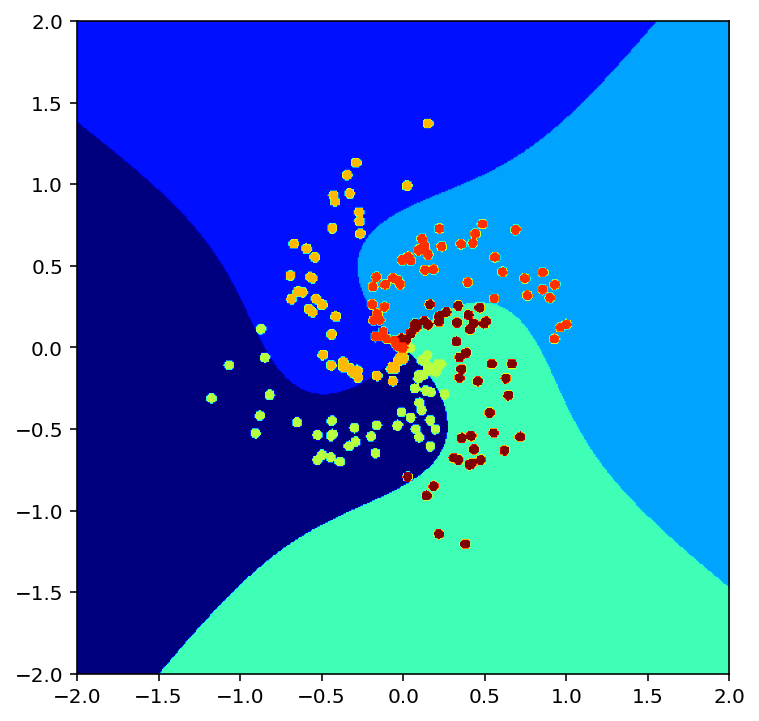

In [32]:
X_all = sample_grid()
poly_X_all = make_poly_features(poly_degree, X_all)    # [TO-DO]
y_pred = poly_net(poly_X_all)
plot_decision_map(X_all, y_pred, X_test, y_test)

# Hinge loss and links to SVMs
[SVM review and hinge loss]

In [33]:
#@title Video 8:

## Exercise 10: Multi-Class Hinge Loss
[Outline the goal and steps and the formula]
The loss corresponding to class j is calculated as follows,
$$
l_j(x, y)=\sum_{j\neq y} \max (0, \operatorname{margin}-x[y]+x[j])
$$
Then it is averaged over all the class elements and all the mini-batch samples.

In [34]:
net = Net('ReLU()', X_train.shape[1], [128], K).to(dev)
criterion = nn.MultiMarginLoss(margin=2.0)    # [TO-DO]
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 100
_, _ = train_test_classification(net, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs)

Accuracy on the 200 training samples: 98.11 %
Accuracy on the 200 testing samples: 98.50 %


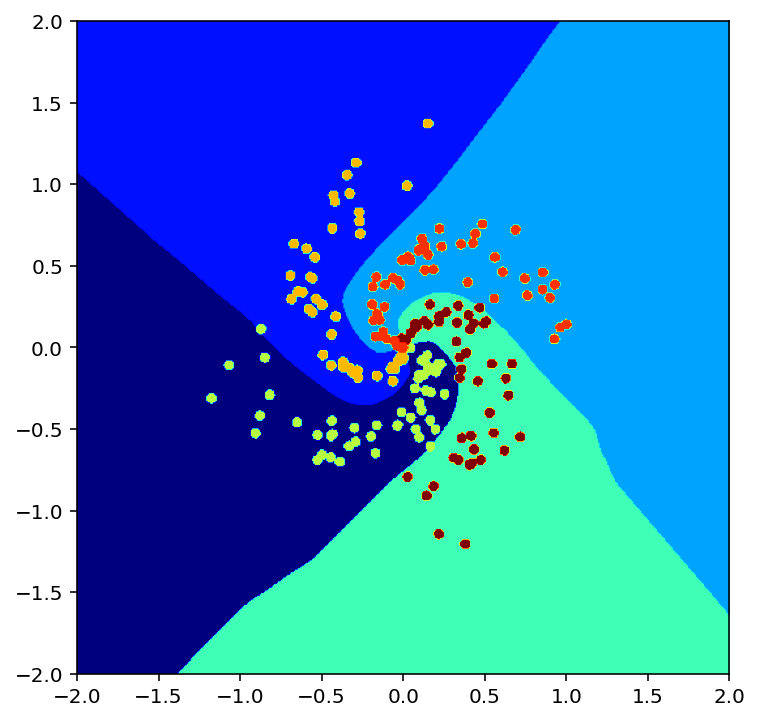

In [35]:
X_all = sample_grid()
y_pred = net(X_all)
plot_decision_map(X_all, y_pred, X_test, y_test)

# Deeper MLPs
[The ability of deeper MLP to approximate a broader set of functions]

In [36]:
#@title Video 9:

## Exercise 11: Classification on a real world dataset
[Outline the goal and steps, introducing the need for augmentation, preprocessing (bring to -1,1 range), small batch_size (due to overfitting), multithreading in data loaders]
[Ask to choose a good choice for augmentation and preprocessing]

In [37]:
# Data Loaders
batch_size = 128
train_transform = transforms.Compose([
     transforms.RandomRotation(10), # [TO-DO]
     transforms.RandomHorizontalFlip(),    # [TO-DO]
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    # [TO-DO] example of a simple one
     ])

data_path = pathlib.Path('.')/'afhq' # using pathlib to be compatible with all OS's
img_train_dataset = ImageFolder(data_path/'train', transform=train_transform)
# num_workers can be set to 10 if running on Colab Pro TPUs
img_train_loader = DataLoader(img_train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=10) 

test_transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))    # [TO-DO]
     ])
img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)
img_test_loader = DataLoader(img_test_dataset, batch_size=batch_size,
                        shuffle=False, num_workers=1)
classes = ('cat', 'dog', 'wild')

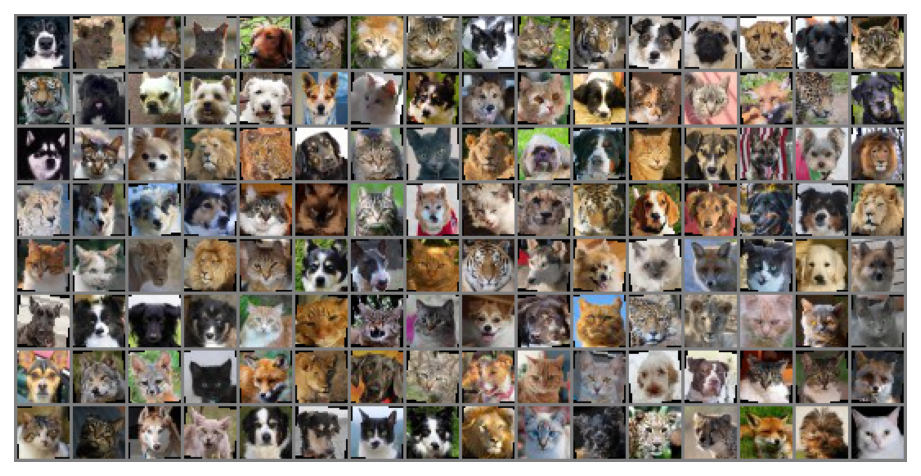

In [38]:
# get some random training images
dataiter = iter(img_train_loader)
images, labels = dataiter.next()

# show images
imshow(make_grid(images, nrow=16))

In [39]:
net = Net('ReLU()', 3*32*32, [128, 32], 3).to(dev) 
criterion = nn.MultiMarginLoss(margin=1.0)    # [TO-DO]
optimizer = optim.Adam(net.parameters(), lr=3e-4)
_, _ = train_test_classification(net, criterion, optimizer,
                                img_train_loader, img_test_loader,
                                num_epochs=50)

Accuracy on the 1500 training samples: 95.83 %
Accuracy on the 1500 testing samples: 90.60 %


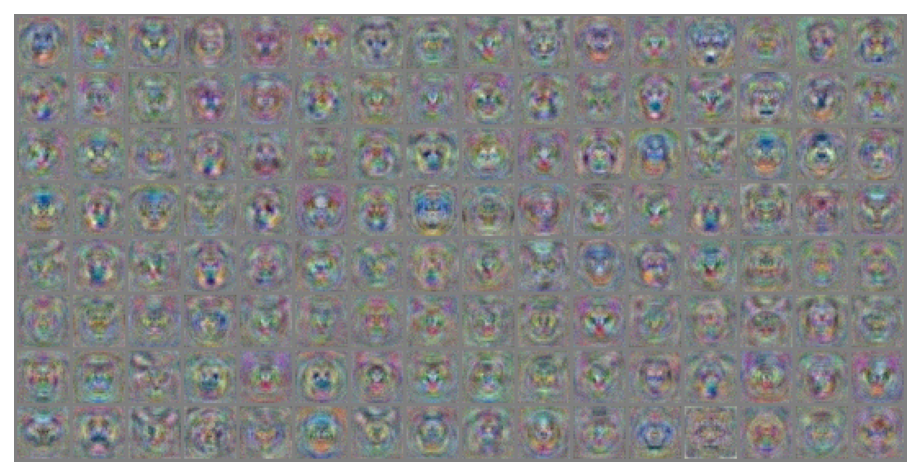

In [40]:
fc1_weights = net.layers[0].weight.view(128, 3, 32, 32).detach().cpu()     # [TO-DO]
fc1_weights /= torch.max(torch.abs(fc1_weights))
imshow(make_grid(fc1_weights, nrow=16))

# The choice of transfer function matters
[introduce different properties of different transfer functions]

In [41]:
#@title Video 10:

## Exercise 12: Find the best transfer function for this model
[categorizing Pytorch transfer functions according to their properties in a table so that students could have a better educated guess on which one to pick instead of trying all!]

In [42]:
# Possible Activations
Activations = ['ReLU', 'Tanh', 'Sigmoid', 'ELU', 'Hardshrink', 'Hardsigmoid',
'Hardtanh', 'Hardswish', 'LeakyReLU', 'LogSigmoid', 'PReLU',
'ReLU6', 'RReLU', 'SELU', 'CELU', 'GELU', 'SiLU', 'Softplus',
'Softshrink', 'Softsign', 'Tanhshrink']

your_picks = ['Hardswish'] # [TO-DO] other picks above 91.5% test accuracy is acceptable

for actv in your_picks:
  print(actv)
  actv = actv+'()'
  net = Net(actv, 3*32*32, [128, 32], 3).to(dev) 
  criterion = nn.MultiMarginLoss(margin=1.0)
  optimizer = optim.Adam(net.parameters(), lr=3e-4)
  _, _ = train_test_classification(net, criterion, optimizer,
                                  img_train_loader, img_test_loader,
                                  num_epochs=50)

Hardswish


Accuracy on the 1500 training samples: 96.75 %
Accuracy on the 1500 testing samples: 91.27 %


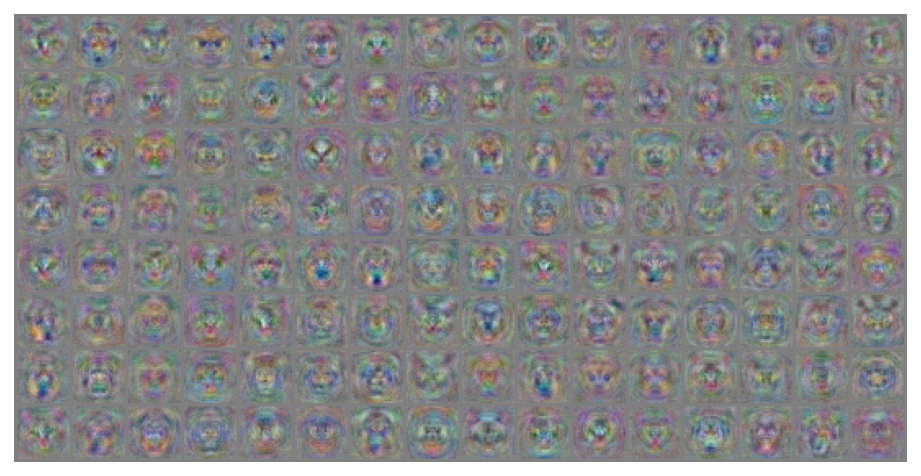

In [43]:
fc1_weights = net.layers[0].weight.view(128, 3, 32, 32).detach().cpu()
fc1_weights /= torch.max(torch.abs(fc1_weights))
imshow(make_grid(fc1_weights, nrow=16))

# The need for good initialization
[The discussion about why optimal gain is dependent with the transfer functions and what is theoretical optimal solution for Leaky ReLU]

In [44]:
#@title Video 11:

## Xavier initialization
Let us look at the scale distribution of an output (e.g., a hidden variable)  $o_i$  for some fully-connected layer without nonlinearities. With  $n_{in}$  inputs  ($x_j$)  and their associated weights  $w_{ij}$  for this layer. Then an output is given by,
$$
o_{i} = \sum_{j=1}^{n_\mathrm{in}} w_{ij} x_j
$$
The weights  $w_{ij}$  are all drawn independently from the same distribution. Furthermore, let us assume that this distribution has zero mean and variance  $\sigma^2$ . Note that this does not mean that the distribution has to be Gaussian, just that the mean and variance need to exist. For now, let us assume that the inputs to the layer  $x_j$ also have zero mean and variance  $\gamma^2$  and that they are independent of $w_{ij}$ and independent of each other. In this case, we can compute the mean and variance of $o_i$ as follows:
\begin{split}\begin{aligned}
    E[o_i] & = \sum_{j=1}^{n_\mathrm{in}} E[w_{ij} x_j] = \sum_{j=1}^{n_\mathrm{in}} E[w_{ij}] E[x_j] = 0, \\
    \mathrm{Var}[o_i] & = E[o_i^2] - (E[o_i])^2 = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij} x^2_j] - 0 = \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij}] E[x^2_j] = n_\mathrm{in} \sigma^2 \gamma^2
\end{aligned}\end{split}
One way to keep the variance fixed is to set $n_{in}\sigma^2=1$ . Now consider backpropagation. There we face a similar problem, albeit with gradients being propagated from the layers closer to the output. Using the same reasoning as for forward propagation, we see that the gradients’ variance can blow up unless $n_{out}\sigma^2=1$ , where  $n_{out}$ is the number of outputs of this layer. This leaves us in a dilemma: we cannot possibly satisfy both conditions simultaneously. Instead, we simply try to satisfy:
\begin{aligned}
\frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ or equivalently }
\sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}
\end{aligned}
This is the reasoning underlying the now-standard and practically beneficial Xavier initialization, named after the first author of its creators [Glorot & Bengio, 2010]. Typically, the Xavier initialization samples weights from a Gaussian distribution with zero mean and variance  $\sigma^2=\frac{2}{(n_{in}+n_{out})}$. We can also adapt Xavier’s intuition to choose the variance when sampling weights from a uniform distribution. Note that the uniform distribution $U(−a,a)$ has variance $\frac{a^2}{3}$. Plugging this into our condition on $\sigma^2$ yields the suggestion to initialize according to
$$
U\left(-\sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}, \sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}\right)
$$
This explanation is mainly taken from [here](https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html).


## Initialization with transfer function
Let's derive the optimal gain for LeakyReLU following a similar steps,

$$
f(x)=\left\{\begin{array}{ll}
a x & \text { for } x<0 \\
x & \text { for } x \geq 0
\end{array}\right.
$$

Considering a single layer with activation gives, 


The expectation of the output is still zero but the variance changes and assuming the probability $P(x < 0) = 0.5$

\begin{split}\begin{aligned}
    \mathrm{Var}[f(o_i)] = E[f(o_i)^2] & = \frac{\mathrm{Var}[o_i] + a^2 \mathrm{Var}[o_i]}{2} = \frac{1+a^2}{2}n_\mathrm{in} \sigma^2 \gamma^2
\end{aligned}\end{split}

Therefore following the rest of derivation as before,

$$
\sigma = gain\sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}, \quad gain = \sqrt{\frac{2}{1+a^2}}
$$

In [45]:
#@title Video 12:

## Exercise 13: Best gain for Xavier Initialization with Leaky ReLU

[]

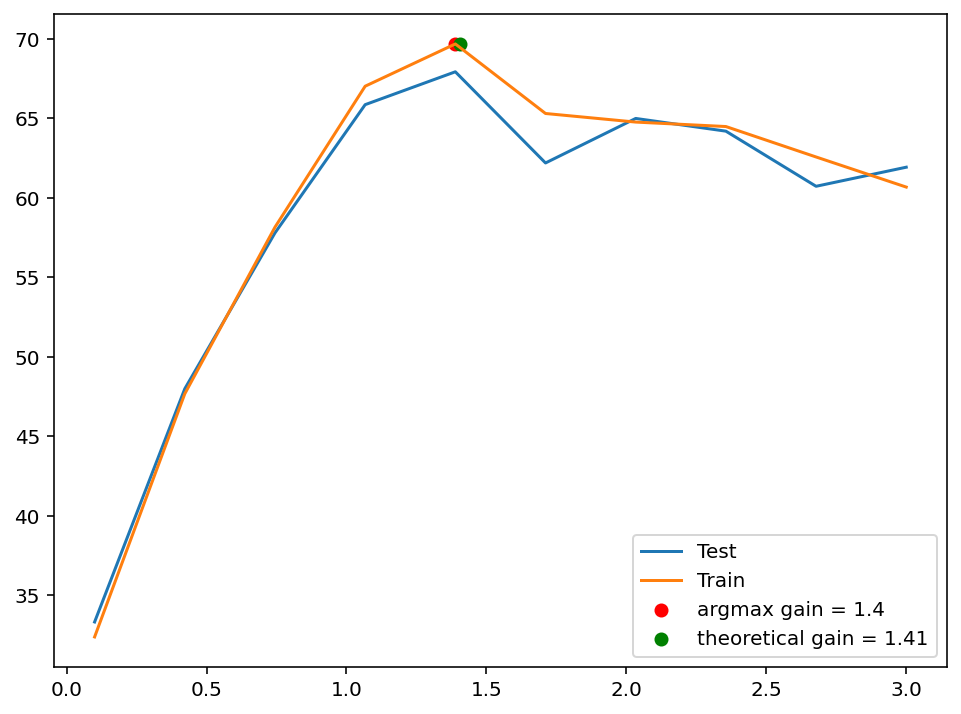

In [46]:
N = 10 # number of trials
gains = np.linspace(1/N, 3.0, N)
test_accs = []
train_accs = []
for gain in gains:

  def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight, gain) # [TO-DO]
        # torch.nn.init.xavier_uniform_(m.weight, gain)

  negative_slope = 0.1
  actv = 'LeakyReLU(%f)'%negative_slope # [TO-DO]
  net = Net(actv, 3*32*32, [128, 64, 32], 3).to(dev) 
  net.apply(init_weights) # [TO-DO]
  criterion = nn.CrossEntropyLoss()
  # criterion = nn.MultiMarginLoss(margin=1.0)
  optimizer = optim.SGD(net.parameters(), lr=1e-2) # [TO-DO]
  train_acc, test_acc = train_test_classification(net, criterion, optimizer,
                                                  img_train_loader, img_test_loader,
                                                  num_epochs=1, verbose=False)
  test_accs += [test_acc]
  train_accs += [train_acc]

best_gain = gains[np.argmax(train_accs)]
plt.plot(gains, test_accs, label='Test')
plt.plot(gains, train_accs, label='Train')
plt.scatter(best_gain, max(train_accs), label='argmax gain = %.1f'%best_gain, c='r')
theoretical_gain = np.sqrt(2.0 / (1 + negative_slope ** 2)) # [TO-DO]
plt.scatter(theoretical_gain, max(train_accs), label='theoretical gain = %.2f'%theoretical_gain, c='g')
plt.legend()
plt.plot()

# Conclusion
[Overcomplete MLPs are good (make link to neural tangent kernels), show how the infinite width limit produces beautifully smooth interpolations]

[High dimensional spaces intuition, the idea of ensemble methods, See how mixing multiple models often helps. Conceptualize ANNs as many models in parallel]

In [47]:
#@title Video 13:

#Feedback
how could this session have been better? How happy are you in your group? How do you feel right now?

In [48]:
# report to Airtable

# Homeworks
* (1) Join the Kaggle Competition to solve Animal Faces with random permutations using MLPs.
* (2) Something where you debug something: Cross-entropy optimization with poor initialization, producing NaNs.
* (3) Something related to ethics: A classification system with interest bias?
* (4) Read some cool original paper:  Kernel vs Rich regimes paper?


# Kaggle competition
https://www.kaggle.com/c/permuted-animal-faces/

preparing the Kaggle dataset by permuting the animal faces

[ To-be removed in the end]

In [49]:

# Datasets
train_transform = transforms.Compose([
     transforms.RandomRotation(10),
     transforms.RandomHorizontalFlip(),
     ])

data_path = pathlib.Path('.')/'afhq' # using pathlib to be compatible with all OS's
img_train_dataset = ImageFolder(data_path/'train', transform=train_transform)

test_transform = transforms.Compose([
     transforms.RandomRotation(10),
     transforms.RandomHorizontalFlip(),
     ])
img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)

In [50]:
rand_perm = np.random.permutation(3*32*32)

In [51]:
import json
with open("rand_perm.txt", "w") as fp:
  json.dump(rand_perm.tolist(), fp)

In [52]:
test_data = np.zeros((len(img_test_dataset), 1+3*32*32),
                     dtype=np.uint8)
for i, data in enumerate(img_test_dataset):
  X, y = data
  X = np.array(X, dtype=np.uint8).reshape(-1)
  X = X[rand_perm]
  test_data[i, 0] = y
  test_data[i, 1:] = X
test_data = np.random.permutation(test_data)

In [53]:
header = []
for i in range(3*32*32):
  header += ['pixel%d'%(i+1)]

import csv
with open('test.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    
    for i in range(test_data.shape[0]):
      data = test_data[i, 1:].tolist()
      writer.writerow(data)

header = ['ImageId', 'Label']
with open('solution.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    
    for i in range(test_data.shape[0]):
      data = [i+1] + [test_data[i, 0]]
      writer.writerow(data)

header = ['ImageId', 'Label']
with open('sampleSubmission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    
    for i in range(test_data.shape[0]):
      writer.writerow([i+1] + [1])

In [54]:
train_data = np.zeros((len(img_train_dataset), 1+3*32*32),
                     dtype=np.uint8)
for i, data in enumerate(img_train_dataset):
  X, y = data
  X = np.array(X, dtype=np.uint8).reshape(-1)
  X = X[rand_perm]
  train_data[i, 0] = y
  train_data[i, 1:] = X
train_data = np.random.permutation(train_data)

In [55]:
header = ["Label"]
for i in range(3*32*32):
  header += ['pixel %d'%(i+1)]

with open('train.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    
    for i in range(train_data.shape[0]):
      data = train_data[i].tolist()
      writer.writerow(data)